## Define the Objective of the Analysis

Analisi del sentiment relativo al dibattito sullo _Smart Working_ in Italia e individuazione di eventuali 'influencer' sul tema.

## Collect Data

In [1]:
# imports
import numpy as np
import pandas as pd
import tweepy
tweepy.__version__

import re
import string
import itertools
from collections import Counter
from datetime import datetime
from numpy.core.multiarray import result_type
import time

In [5]:
from tqdm.notebook import tqdm
import json

In [2]:
# insert the keys here
consumer_key = 'VPzjkqKl2y1uSTJQvnVqS9e1X' 
consumer_secret = 'STG2IzVMf65vPGeOvBQyzdeoKBExAr5sIkhOaBeDe2fnIN14vY'
access_token = '1508409949835214853-HIyZJ3oT32TijKsdNDhGFZEEQTWwau'
access_token_secret = 'uLcs9hUYmLdocxkaSfXo69Gii46TISu5qZj5F6f6fBfnW'

#### Tweets Download

The next step is creating an OAuthHandler instance. We pass our consumer key and access token which we defined above.

In [3]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

Next, we pass the OAuthHandler instance into the API method.

In [4]:
api = tweepy.API(auth, wait_on_rate_limit=True)

Tweets that contain a specific keyword

In [ ]:
keywords = '("smartworking" OR "remotework" OR "lavoroagile" OR "hybridwork" OR "smart working" OR "remote work" OR "lavoro agile" OR "hybrid work")'

list_tweets = []

for tweet in tweepy.Cursor(api.search_tweets, q=keywords, count=100, lang='it').items(10000):
  print('entering')
  full_text = api.get_status(tweet.id, tweet_mode='extended')._json['full_text']
  print(tweet.id)
  list_tweets.append([tweet.created_at, tweet.id, full_text, tweet.favorite_count, tweet.retweet_count, tweet.user.screen_name,
                      tweet.user.location, tweet.retweeted, json.dumps(tweet.entities['user_mentions']), json.dumps(tweet.entities['hashtags'])])

# items is the maximum number of tweets to download.
# count is the number of tweets to return per page, up to a maximum of 100.

In [7]:
print(len(list_tweets))

2667


In [8]:
# Turn list_tweet into a DataFrame changing column names
tweets = pd.DataFrame(list_tweets, columns=['date','id','text','like','n_rt','author','location','retweeted','user_mentions','hastags'])
tweets.to_csv('../data/SW_final.csv')

In [9]:
# Read csv
#tweets = pd.read_csv('../data/SW_ex.csv')
#tweets_loaded = tweets_loaded.drop('Unnamed: 0', axis=1)
tweets.head()

,date,id,text,like,n_rt,author,location,retweeted,user_mentions,hastags
0,2023-01-05 20:15:42+00:00,1611094108889563141,@giorgeliot Sì infatti stavo giusto scrivendo ...,1,0,Stormtrooper528,Italia,False,"[{""screen_name"": ""giorgeliot"", ""name"": ""Silvia...",[]
1,2023-01-05 20:07:49+00:00,1611092122370727975,RT @mrmcphisto: la @lauraravetto dice che la m...,0,19,Alessan83492964,,False,"[{""screen_name"": ""mrmcphisto"", ""name"": ""mrmcph...","[{""text"": ""smartworking"", ""indices"": [99, 112]..."
2,2023-01-05 19:53:07+00:00,1611088423930171392,RT @mrmcphisto: la @lauraravetto dice che la m...,0,19,SusannaPagani3,,False,"[{""screen_name"": ""mrmcphisto"", ""name"": ""mrmcph...","[{""text"": ""smartworking"", ""indices"": [99, 112]..."
3,2023-01-05 19:50:39+00:00,1611087802560569345,RT @mrmcphisto: la @lauraravetto dice che la m...,0,19,DonatellaRento,,False,"[{""screen_name"": ""mrmcphisto"", ""name"": ""mrmcph...","[{""text"": ""smartworking"", ""indices"": [99, 112]..."
4,2023-01-05 19:28:34+00:00,1611082245514706944,RT @mrmcphisto: la @lauraravetto dice che la m...,0,19,RobertaCannas2,,False,"[{""screen_name"": ""mrmcphisto"", ""name"": ""mrmcph...","[{""text"": ""smartworking"", ""indices"": [99, 112]..."


In [10]:
print(tweets.shape)
print(tweets.columns)

(2667, 10)
Index(['date', 'id', 'text', 'like', 'n_rt', 'author', 'location', 'retweeted',
       'user_mentions', 'hastags'],
      dtype='object')


#### Data Pre-Processing

In [11]:
# Remove duplicates
tweets.drop_duplicates(subset ="id", inplace = True)
tweets.reset_index(drop = True, inplace = True)
tweets.shape

(2667, 10)

In [12]:
# Change date format
day = tweets['date'].dt.day
month = tweets['date'].dt.month
year = tweets['date'].dt.year

date = year.astype(str) + month.astype(str).str.zfill(2) + day.astype(str).str.zfill(2)
date = pd.to_datetime(date, format='%Y%m%d')
tweets.drop(columns = ['date'], inplace = True)
tweets['date'] = date

# Reorder columns
cols = tweets.columns.tolist()
cols = cols[-1:] + cols[:-1]
tweets = tweets[cols].copy()

print('Tweet per day:')
print()
print(tweets.groupby('date').count()['id'])

Tweet per day:

date
2022-12-26     59
2022-12-27    386
2022-12-28    331
2022-12-29    204
2022-12-30    562
2022-12-31    276
2023-01-01    147
2023-01-02    158
2023-01-03    169
2023-01-04    227
2023-01-05    148
Name: id, dtype: int64


Come possiamo osservare dalla distribuzione del numero di tweet nei giorni presi in considerazione, ...

In [13]:
# Create a DataFrame with the authors of the tweets and their respective frequency
freq_authors = tweets['author'].value_counts()
freq_authors.head()

mrmcphisto         44
infoitinterno      41
aleale2780         29
saragra98354743    23
lucague46760617    22
Name: author, dtype: int64

In [14]:
# Extract all hashtags from the full text
tweets['hashtags_list'] = tweets['text'].apply(lambda x: re.findall(r"#(\w+)", x))

# Extract all mentions from the full text
tweets['mentions'] = tweets['text'].apply(lambda x: re.findall(r"@(\w+)", x))

# \w matches any single letter, number or underscore (same as [a zA Z0 9_])

#### Data Cleaning

NLTK - Natural Language ToolKit is a platform for building Python programs to work with human language data. It provides easy to use interfaces to over 50 corpora and lexical resources, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning.

In [15]:
import nltk
from nltk import FreqDist
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\FC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\FC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\FC\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Text Pre-Processing

In [16]:
def preprocess_data(data):
    # remove numbers and turning words into lower case
    data = data.astype(str).str.replace('\d+','')
    lower_text = data.str.lower()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    w_tokenizer = TweetTokenizer()
    
    # token lemmatization (ex. goes --> go)
    def lemmatize_text(text):
        return[(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize((text))]
    
    # remove punctuation
    def remove_punctuation(words):
        new_words = []
        for word in words:
            new_word = re.sub(r'[\w\s]', '', (word))
            if new_word != '':
                new_words.append(new_word)
        return new_words
    
    words = lower_text.apply(lemmatize_text)
    words = words.apply(remove_punctuation)
    return pd.DataFrame(words)

In [17]:
# apply preprocess_data function
pre_tweets = preprocess_data(tweets['text'])
tweets['text_proc'] = pre_tweets

# delete italian stopwords
stop_words = set(stopwords.words('italian'))
tweets['text_proc'] = tweets['text_proc'].apply(lambda x: [item for item in x if item not in stop_words])

C:\Users\FC\AppData\Local\Temp\ipykernel_17020\3179111472.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data = data.astype(str).str.replace('\d+','')


## Analysis

### Social Content Analysis

#### _Sentiment Analysis_

FEEL-IT: Emotion and Sentiment Classification for the Italian Language.

https://towardsdatascience.com/sentiment-analysis-and-emotion-recognition-in-italian-using-bert-92f5c8fe8a2

In [18]:
from feel_it import EmotionClassifier, SentimentClassifier

sentiment_classifier = SentimentClassifier()
emotion_classifier = EmotionClassifier()

c:\Users\FC\miniconda3\envs\twitter\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The feel-it-italian-sentiment model performs sentiment analysis on Italian. We fine-tuned the UmBERTo model on our new dataset (i.e., FEEL-IT) obtaining state-of-the-art performances on different benchmark corpora.

In [ ]:
# print(sentiment_classifier.predict(tweets["text"].values.tolist()))

In [19]:
tweets_sentiment = tweets.copy()

In [20]:
text = tweets_sentiment['text']
li_sent = []
for i in range(0, text.shape[0]):
  sent = sentiment_classifier.predict([text[i]])
  li_sent.append(sent)

tweets_sentiment['sentiment_BERT'] = [item for sublist in li_sent for item in sublist]
     
positive = []
negative = []

In [21]:
tweets_sentiment.columns

Index(['date', 'id', 'text', 'like', 'n_rt', 'author', 'location', 'retweeted',
       'user_mentions', 'hastags', 'hashtags_list', 'mentions', 'text_proc',
       'sentiment_BERT'],
      dtype='object')

In [22]:
positive = []
negative = []
ratio = []

for line in tweets_sentiment.values:
  sent = line[13]

  if sent == 'negative':
    positive.append(0)
    negative.append(1)
    ratio.append(-1)
  else:
    positive.append(1)
    negative.append(0)
    ratio.append(1)

In [23]:
tweets_sentiment['positive'] = positive
tweets_sentiment['negative'] = negative
tweets_sentiment['ratio'] = ratio

In [24]:
tweets_sentiment.to_csv('../data/SW_sentiment_final.csv')

#### _Emotion Analysis_

Recognizing emotions in text is fundamental to get a better sense of how people are talking about something. People can talk about a new event, but positive/negative labels might not be enough.

The feel-it-italian-emotion model performs emotion classification (joy, fear, anger, sadness) on Italian. We fine-tuned the UmBERTo model on our new dataset (i.e., FEEL-IT) obtaining state-of-the-art performances on different benchmark corpora.

In [25]:
tweets_emotion = tweets.copy()

In [26]:
text = tweets_emotion['text']
li_emotion = []
for i in range(0, text.shape[0]):
  emotion = emotion_classifier.predict([text[i]])
  li_emotion.append(emotion)

tweets_emotion['emotion_BERT'] = [item for sublist in li_emotion for item in sublist]
     
anger = []
joy = []
fear = []
sadness = []

In [27]:
anger = []
joy = []
fear = []
sadness = []

for line in tweets_emotion.values:
  emotion = line[13]

  if emotion == 'anger':
    anger.append(1)
    joy.append(0)
    fear.append(0)
    sadness.append(0)
  elif emotion == 'joy':
    anger.append(0)
    joy.append(1)
    fear.append(0)
    sadness.append(0)
  elif emotion == 'fear':
    anger.append(0)
    joy.append(0)
    fear.append(1)
    sadness.append(0)
  else:
    anger.append(0)
    joy.append(0)
    fear.append(0)
    sadness.append(1)

In [28]:
tweets_emotion['anger'] = anger
tweets_emotion['joy'] = joy
tweets_emotion['fear'] = fear
tweets_emotion['sadness'] = sadness

In [29]:
tweets_emotion.to_csv('../data/SW_emotion_final.csv')

---

#### Social Network Analysis

In [1]:
import pandas as pd 


In [2]:
tweets = pd.read_csv('../data/SW_final.csv')

In [3]:
author_mentions = tweets[['author', 'user_mentions']]
author_mentions.head()

,author,user_mentions
0,Stormtrooper528,"[{""screen_name"": ""giorgeliot"", ""name"": ""Silvia..."
1,Alessan83492964,"[{""screen_name"": ""mrmcphisto"", ""name"": ""mrmcph..."
2,SusannaPagani3,"[{""screen_name"": ""mrmcphisto"", ""name"": ""mrmcph..."
3,DonatellaRento,"[{""screen_name"": ""mrmcphisto"", ""name"": ""mrmcph..."
4,RobertaCannas2,"[{""screen_name"": ""mrmcphisto"", ""name"": ""mrmcph..."


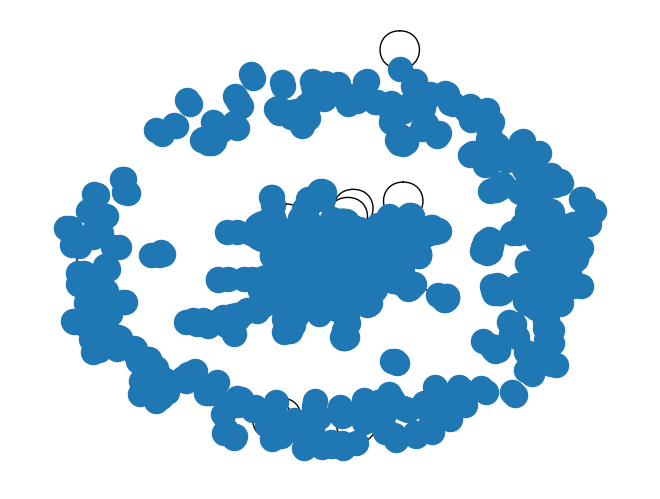

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import json
Graph = nx.Graph()

for index, row in author_mentions.iterrows():
  mentions_array = json.loads(row[1])
  for item in mentions_array:
    Graph.add_edge(row[0], item['screen_name'])
nx.draw(Graph, pos=nx.spring_layout(Graph))

In [7]:
len(Graph.edges())

2568

In [10]:
nodes_degree_df = pd.DataFrame(nx.degree(Graph))
nodes_degree_df.sort_values(1, ascending=False).head(20)
# nodes_degree = [row for index, row in nodes_degree_df.iterrows() if row[1] > 2]

,0,1
890,BonomiAllegra,210
3,mrmcphisto,145
59,GiorgiaMeloni,141
377,AlbertoBagnai,118
60,ClaudioDurigon,82
284,PaoloZangrillo,75
13,bioccolo,68
629,mvetto,64
200,LucillaMasini,64
44,aleale2780,58


#### _Measures of Centrality_

Nodes with Highest Degree

In [12]:
nodes_degree_df.sort_values(1, ascending=False).head(15)

,0,1
890,BonomiAllegra,210
3,mrmcphisto,145
59,GiorgiaMeloni,141
377,AlbertoBagnai,118
60,ClaudioDurigon,82
284,PaoloZangrillo,75
13,bioccolo,68
629,mvetto,64
200,LucillaMasini,64
44,aleale2780,58


Average Degree

In [13]:
import numpy as np
degree_data = nodes_degree_df[1].values
average_degree = np.average(degree_data)
print(f'The average degree of the graph is: {average_degree}')

The average degree of the graph is: 2.821978021978022


Siccome il grado medio è maggiore di 1, molto probabilmente è sorta una giant component

Calcolo Assortativity

In [9]:
assortativity = nx.degree_pearson_correlation_coefficient(Graph)
print(f'The assortativity coefficient is: {assortativity}')

The assortativity coefficient is: -0.24426525704675425


Stranamente, nonostante la rete presa in esame sia una rete sociale, il coefficiente di assortativity è minore di 0, anche se di poco, quindi la rete è di tipo disassortative

In [10]:
len(nodes_degree)
nodes_degree[0]

0    Alessan83492964
1                  4
Name: 2, dtype: object

#### _Community Detection_

In [11]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Plasma256
from bokeh.transform import linear_cmap

from networkx.algorithms import community as networkxCommunity

In [14]:
communities = networkxCommunity.greedy_modularity_communities(Graph)

In [15]:
modularity_class = {}
modularity_color = {}

for community_number, community in enumerate(communities):
    for name in community:
        
        modularity_class[name] = community_number
        modularity_color[name] = Plasma256[community_number]

In [16]:
nx.set_node_attributes(Graph, modularity_class, 'modularity_class')
nx.set_node_attributes(Graph, modularity_color, 'modularity_color')
nx.set_node_attributes(Graph, modularity_class, 'group')

In [17]:
from collections import Counter
Counter(modularity_class).most_common()
comm_list = [modularity_class[x] for x in modularity_class]

count_dict = {}

for item in comm_list:
  if str(item) not in count_dict:
    count_dict[str(item)] = 1
  else:
    count_dict[str(item)] += 1

In [27]:
from pyvis.network import Network

nt = Network('1080px', '1920px', notebook=True, cdn_resources='remote')
nt.from_nx(Graph)
nt.show('./nx.html')

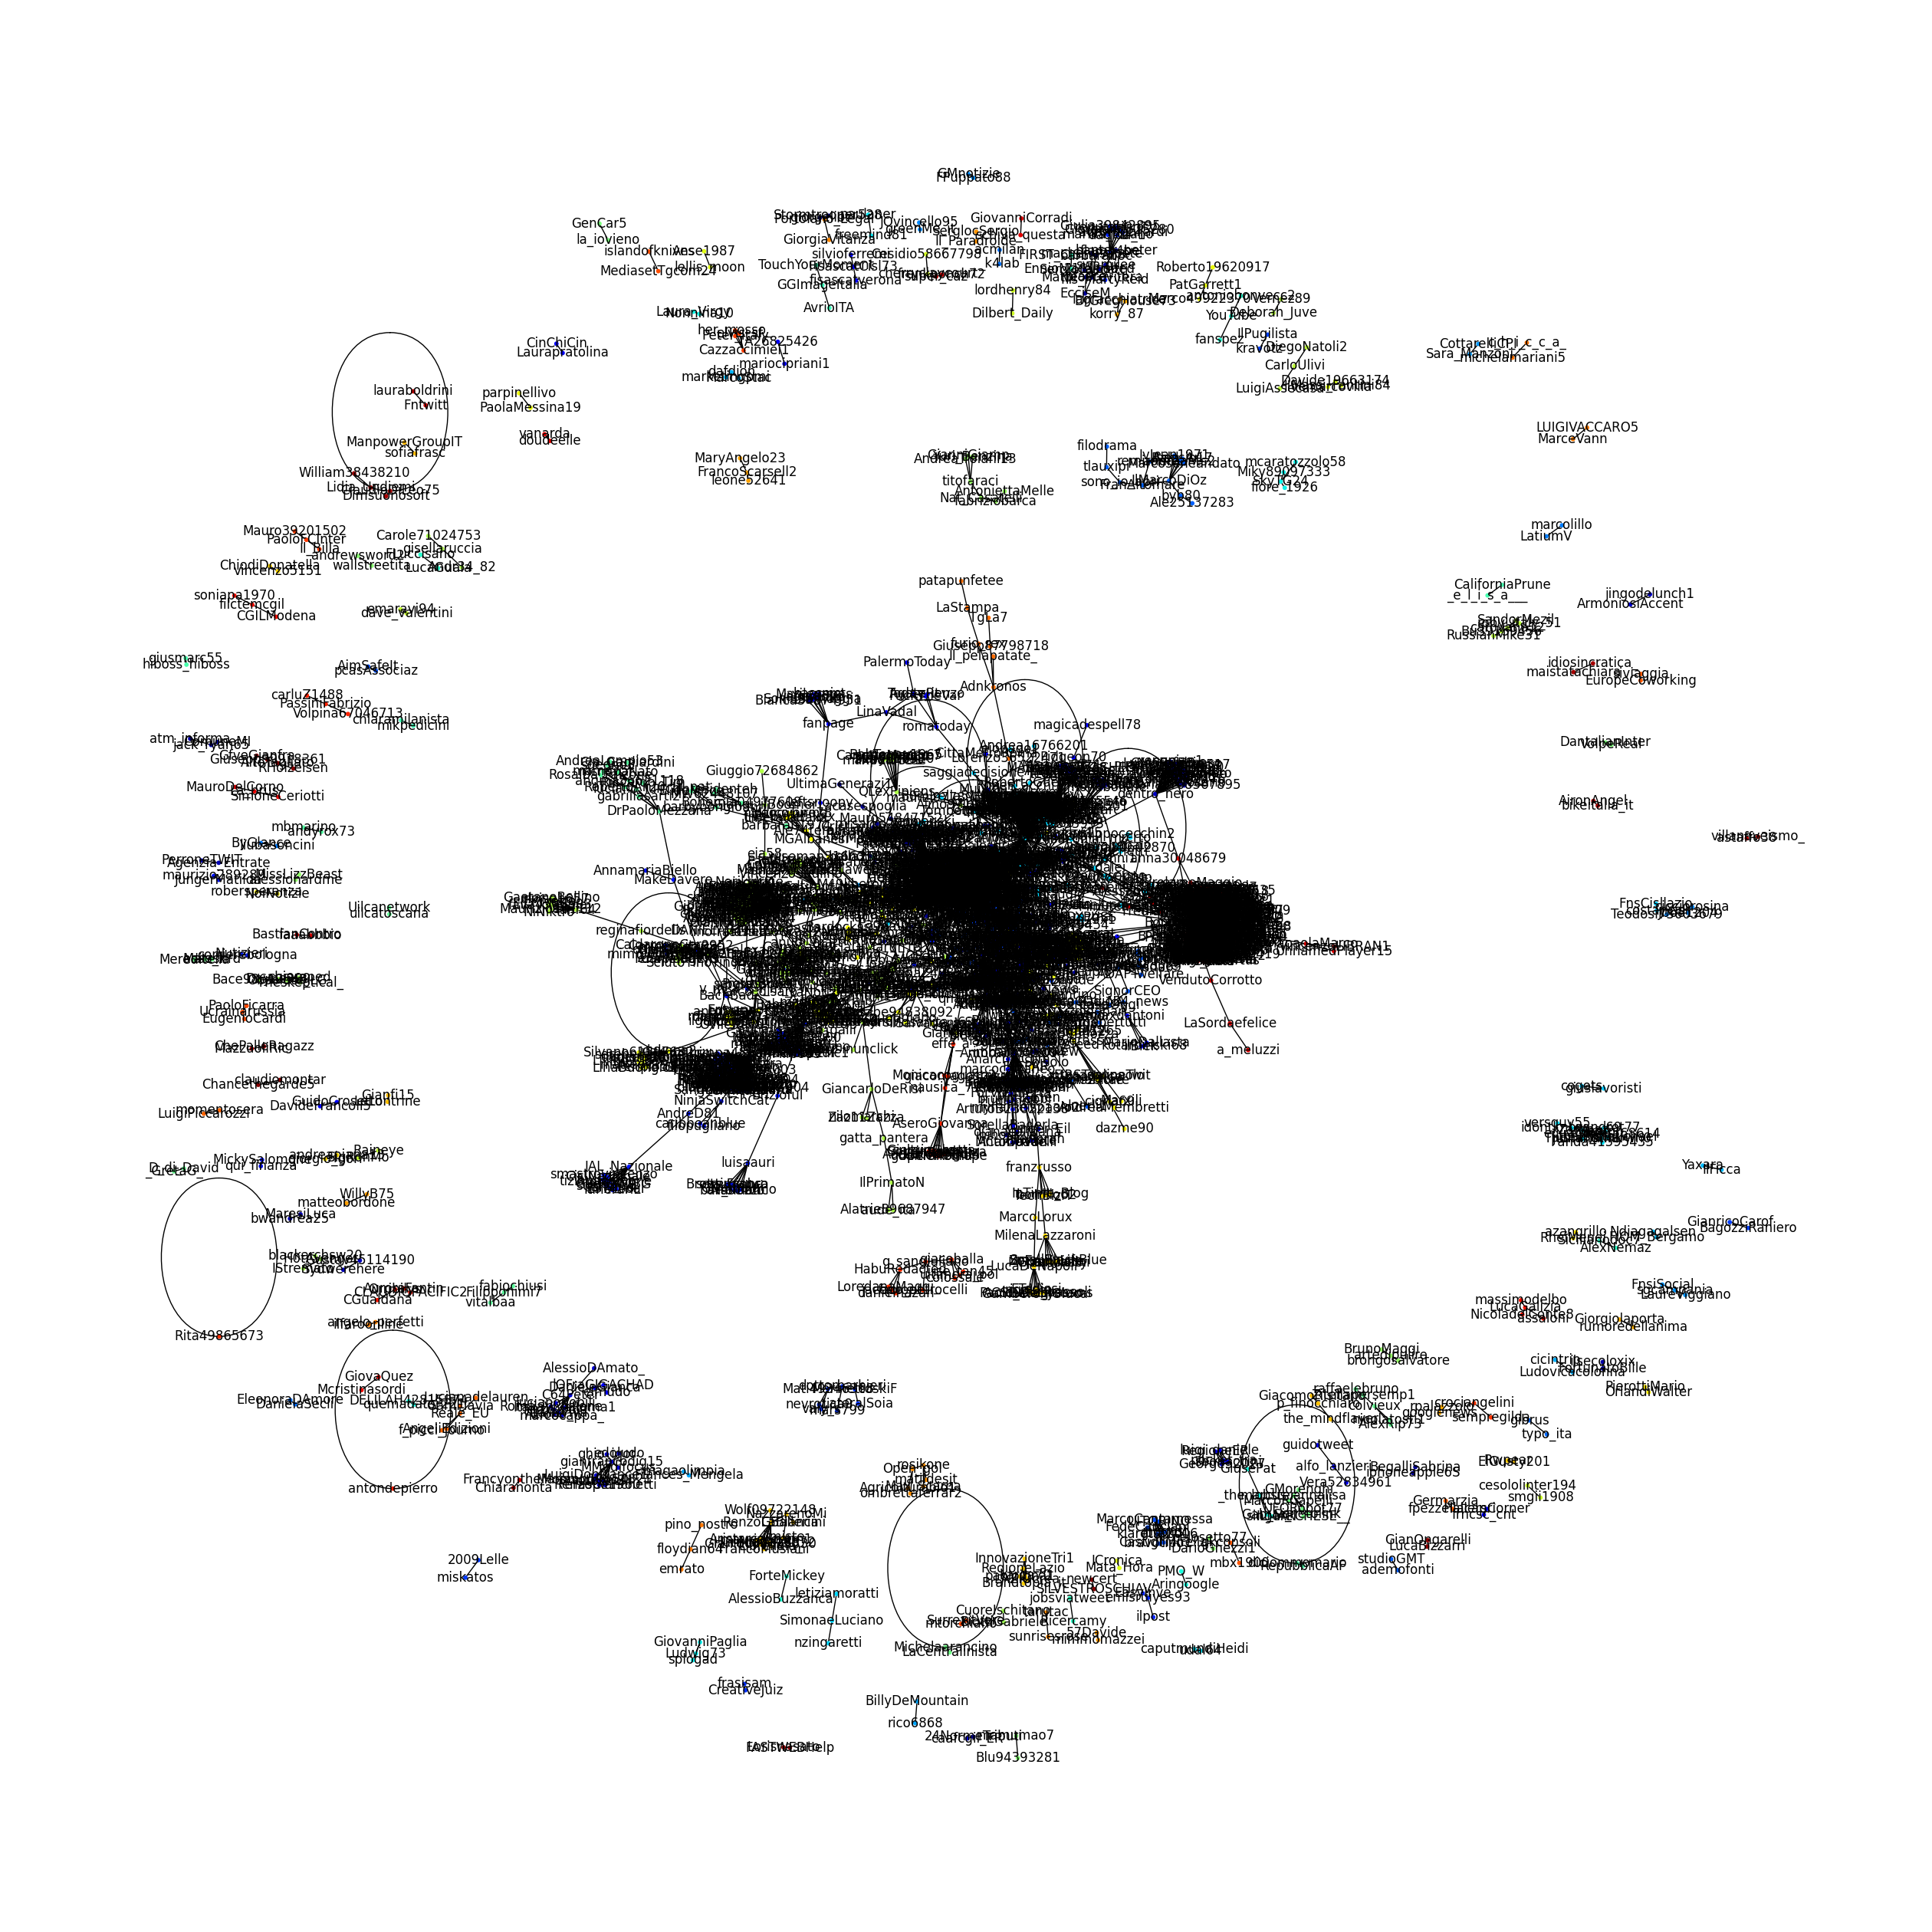

In [21]:
from community import community_louvain

best_partitioon = community_louvain.best_partition(Graph)
modularity = community_louvain.modularity(best_partitioon, Graph)

nodes = [best_partitioon.get(node) for node in Graph.nodes()]

plt.figure(figsize=(25, 25))
nx.draw_spring(Graph, cmap=plt.get_cmap('jet'), node_color=nodes,
               node_size=10, with_labels=True)

## Visualization

In [24]:
import plotly.express as px

vis_dataframe = pd.DataFrame(columns=['comm_number', 'count'])

# count_dict
for key in count_dict:
  vis_dataframe.loc[len(vis_dataframe)] = [key, count_dict[key]]
fig = px.bar(vis_dataframe, x='comm_number', y='count', title='Bar chart of found communities numerosity', labels={
  'comm_number': 'Community number',
  'count': 'Community size'
})

fig.show()